# VGK Project 7 - Recommendation Systems

# Objective: 
Build a recommendation system to recommend products to
customers based on the their previous ratings for other
products.

# Details

### Data Description: 

Amazon Reviews data (​data source​) The repository has several datasets. For this case study, we are using the Electronics dataset.

### Domain:
E-commerce

### Context:
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.


### Attribute Information:
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user 
- timestamp : Time of the rating ( ignore this column for this exercise)


### Learning Outcomes: 
- Exploratory Data Analysis
- Creating a Recommendation system using real data
- Collaborative filtering

### References
1. Recommendation Systems and and its applications (http://www.ijircce.com/upload/2014/august/5_ASurvey.pdf)
2. Use cases of Recommendation systems (https://emerj.com/ai-sector-overviews/use-cases-recommendation-systems/)
3. Kaggle Netflix reco systems (https://www.kaggle.com/laowingkin/netflix-movie-recommendation)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (2.5 Marks)

In [2]:
#Data Import
#Read and explore the dataset. ( Rename column, plot histograms, find data characteristics)
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', names=["userId", "productId", "rating", "timestamp"])#, header=None)

In [3]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  4


In [5]:
#Check Data types
df.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [6]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
rating       0
timestamp    0
dtype: int64


There are no missing values with total records 7824482

In [7]:
# Summary statistics of 'rating' variable
df['rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['rating'].min()))
print('The maximum rating is: %d' %(df['rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5

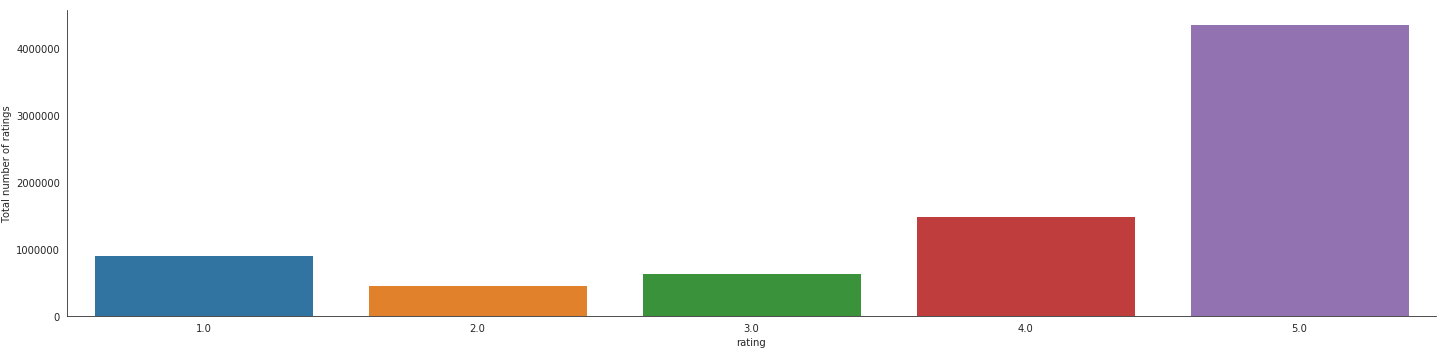

In [9]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=4.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [10]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['productId'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### 2. Take a subset of the dataset to make it less sparse/ denser.( For example, keep the users only who has given 50 or more number of ratings ) - (2.5 Marks)

In [11]:
# Top 10 users based on rating
most_rated = df.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

### Limiting data set to only those users who have given 50 or more ratings

In [12]:
counts = df['userId'].value_counts()
df_final = df[df['userId'].isin(counts[counts >= 50].index)]

In [13]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userId'].nunique())
print('Number of unique PRODUCTS in final data = ', df_final['productId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique PRODUCTS in final data =  48190


In [14]:
df_final.shape

(125871, 4)

In [15]:
df_final.head(10)

,userId,productId,rating,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1003,A2Y4H3PXB07WQI,0972683275,4.0,1292457600
1138,A25RTRAPQAJBDJ,0972683275,5.0,1329523200
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1322,A1A5KUIIIHFF4U,1400501466,1.0,1332547200


### df_final has users who have rated 50 or more items .. Still we have 1.25 lac people.. damn this online retail boom

Calculate the density of the rating matrix

In [16]:
final_ratings_matrix = df_final.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [17]:
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (2.5 Marks)

In [19]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,rating,timestamp
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [20]:
train_data.shape
test_data.shape

(88109, 4)

(37762, 4)

### 4. Build Popularity Recommender model. - (20 Marks)

### Dont need train test for popularity models, also we can take the unfiltered list also to compara

In [21]:
#Count of user_id for each unique product as recommendation score 
data_grouped = df_final.groupby('productId').agg({'userId': 'count'}).reset_index()
data_grouped.rename(columns = {'userId': 'score'},inplace=True)
data_grouped.head(10)

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [22]:
#Sort the products on recommendation score 
data_sort = data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
data_sort['Rank'] = data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = data_sort.head(10) 
popularity_recommendations 

,productId,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0
38611,B00829THK0,137,6.0
39338,B008DWCRQW,137,7.0
21982,B002R5AM7C,128,8.0
28761,B004CLYEDC,118,9.0
22210,B002SZEOLG,113,10.0


In [23]:
# Use popularity based recommender model to make predictions
def recommend(user_id, recoModel):     
    user_recommendations = recoModel 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [24]:
find_recom = [6595853,4175596,1734767]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, popularity_recommendations))    
    print("\n") 

Here is the recommendation for the userId: 6595853

        userId   productId  score  Rank
39003  6595853  B0088CJT4U    206   1.0
24827  6595853  B003ES5ZUU    184   2.0
11078  6595853  B000N99BBC    167   3.0
38250  6595853  B007WTAJTO    164   4.0
38615  6595853  B00829TIEK    149   5.0
38611  6595853  B00829THK0    137   6.0
39338  6595853  B008DWCRQW    137   7.0
21982  6595853  B002R5AM7C    128   8.0
28761  6595853  B004CLYEDC    118   9.0
22210  6595853  B002SZEOLG    113  10.0


Here is the recommendation for the userId: 4175596

        userId   productId  score  Rank
39003  4175596  B0088CJT4U    206   1.0
24827  4175596  B003ES5ZUU    184   2.0
11078  4175596  B000N99BBC    167   3.0
38250  4175596  B007WTAJTO    164   4.0
38615  4175596  B00829TIEK    149   5.0
38611  4175596  B00829THK0    137   6.0
39338  4175596  B008DWCRQW    137   7.0
21982  4175596  B002R5AM7C    128   8.0
28761  4175596  B004CLYEDC    118   9.0
22210  4175596  B002SZEOLG    113  10.0


Here is the 

In [25]:
#Full Unfiltered lesser filter becuase raw data is giving excetpion
df_final_full = df[df['userId'].isin(counts[counts >= 30].index)]
final_ratings_matrix_full = df_final_full.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix_full.shape)

given_num_of_ratings_full = np.count_nonzero(final_ratings_matrix_full)
print('given_num_of_ratings = ', given_num_of_ratings_full)
possible_num_of_ratings_full = final_ratings_matrix_full.shape[0] * final_ratings_matrix_full.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings_full)
density_full = (given_num_of_ratings_full/possible_num_of_ratings_full)
density_full *= 100
print ('density: {:4.2f}%'.format(density_full))

Shape of final_ratings_matrix:  (5276, 81228)
given_num_of_ratings =  262917
possible_num_of_ratings =  428558928
density: 0.06%


In [26]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_full_T = final_ratings_matrix_full.transpose()
final_ratings_matrix_full_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A10471FSILZ25C,A105S56ODHGJEK,A105TOJ6LTVMBG,A107CTGSINY3GJ,A107K10JTO8NSH,A108EEYSHGDL6O,A108GOZ37A7B75,A108J5O7DG2WIM,...,AZPOUCM043IY8,AZPZROZJIKBE8,AZQGJ5CEAJGXB,AZS0Q5ILAQBBR,AZU2Z1Y81YR0T,AZV2U6GU5QA6C,AZWQEM8GKXQ5Y,AZYJE40XW6MFG,AZZ2DEE2NTIM7,AZZYW4YOE1B6E
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0979526191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Count of user_id for each unique product as recommendation score 
data_full_grouped = df.groupby('productId').agg({'userId': 'count'}).reset_index()
data_full_grouped.rename(columns = {'userId': 'score'},inplace=True)
data_full_grouped.head(10)

,productId,score
0,0132793040,1
1,0321732944,1
2,0439886341,3
3,0511189877,6
4,0528881469,27
5,0558835155,1
6,059400232X,3
7,0594012015,8
8,0594017343,1
9,0594017580,1


In [28]:
#Sort the products on recommendation score 
data_full_sort = data_full_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
data_full_sort['Rank'] = data_full_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_full_recommendations = data_full_sort.head(10) 
popularity_full_recommendations 

,productId,score,Rank
308398,B0074BW614,18244,1.0
429572,B00DR0PDNE,16454,2.0
327308,B007WTAJTO,14172,3.0
102804,B0019EHU8G,12285,4.0
296625,B006GWO5WK,12226,5.0
178601,B003ELYQGG,11617,6.0
178813,B003ES5ZUU,10276,7.0
323013,B007R5YDYA,9907,8.0
289775,B00622AG6S,9823,9.0
30276,B0002L5R78,9487,10.0


In [29]:
find_recom = [6595853,4175596,1734767]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, popularity_full_recommendations))    
    print("\n") 

Here is the recommendation for the userId: 6595853

         userId   productId  score  Rank
308398  6595853  B0074BW614  18244   1.0
429572  6595853  B00DR0PDNE  16454   2.0
327308  6595853  B007WTAJTO  14172   3.0
102804  6595853  B0019EHU8G  12285   4.0
296625  6595853  B006GWO5WK  12226   5.0
178601  6595853  B003ELYQGG  11617   6.0
178813  6595853  B003ES5ZUU  10276   7.0
323013  6595853  B007R5YDYA   9907   8.0
289775  6595853  B00622AG6S   9823   9.0
30276   6595853  B0002L5R78   9487  10.0


Here is the recommendation for the userId: 4175596

         userId   productId  score  Rank
308398  4175596  B0074BW614  18244   1.0
429572  4175596  B00DR0PDNE  16454   2.0
327308  4175596  B007WTAJTO  14172   3.0
102804  4175596  B0019EHU8G  12285   4.0
296625  4175596  B006GWO5WK  12226   5.0
178601  4175596  B003ELYQGG  11617   6.0
178813  4175596  B003ES5ZUU  10276   7.0
323013  4175596  B007R5YDYA   9907   8.0
289775  4175596  B00622AG6S   9823   9.0
30276   4175596  B0002L5R78   948

### Considering more data , the popularity based recommendation is different. Also with full data i am getting out of memory error :)

### Since this is a popularity-based recommender model, recommendations remain the same for all users. We predict the products based on the popularity. It is not personalized to particular user

Also there is no purpse of train and test or model accuracy here.. 

### 5. Build Collaborative Filtering model. - (20 Marks)

### Model-based Collaborative Filtering: Singular Value Decomposition

In [30]:
df_final.shape

(125871, 4)

In [31]:
train_data.shape

(88109, 4)

In [32]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,rating,timestamp
0,6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
1,4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
2,4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3,3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
4,1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [33]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
pivot_df.shape
pivot_df.head()

(1540, 48190)

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [35]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVD method

## SVD is best to apply on a large sparse matrix

In [36]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition.
SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent 
Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [37]:
user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [38]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [39]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 2
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.464528
B00829TIEK                  0.0          1.271871
B004CLYEDC                  0.0          1.251298
B00829THK0                  0.0          1.097851
B0034CL2ZI                  0.0          0.803442
B00834SJSK                  0.0          0.801665
B00829TIA4                  0.0          0.798920
B004CLYEFK                  0.0          0.751124
B00834SJNA                  0.0          0.746606
B004T9RR6I                  0.0          0.721282


### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error(RMSE) on predictions made on the test data.) - (7.5 Marks)

### Evaluation of Model-based Collaborative Filtering (SVD)

In [40]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [42]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [43]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [44]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [45]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



### Good accuracy obtained

### Just trying the surprise package also
Ref :: https://surprise.readthedocs.io/en/stable/getting_started.html

In [46]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-surprise

In [47]:
from surprise import SVD
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

In [48]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_final[['userId', 'productId', 'rating']], reader)

In [49]:
# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=False)

0.9774461818626107

0.9916076021209609

0.9894477823308591

0.9806442614510988

0.981313535038795

In [50]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9892601034442997
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7.5 Marks)

In [51]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


### 8. Summarise your insights. - (7.5 marks)

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the historic data of user + product interaction

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be 
not suitable to the user. All users get the same popularity model output. 

Also, large data leads to out of memory, when dealing with both popularity & collaborative filter based model